<a href="https://colab.research.google.com/github/kbrezinski/JAX-Practice/blob/main/jax_more_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
import jax.numpy as jnp
from jax import random

import numpy as np
import functools
import matplotlib.pyplot as plt

from jax import grad, jit, vmap, pmap
from copy import deepcopy
from typing import Tuple, NamedTuple

In [2]:
## Setup PRNG
seed = 0
state = jax.random.PRNGKey(seed)
state1, state2 = jax.random.split(state)

In [9]:
class Counter:
  def __init__(self):
    self.n = 0

  def count(self) -> int:
    self.n += 1
    return self.n

  def reset(self):
    self.n = 0

counter = Counter()
for i in range(3):
  print(counter.count())  # counter works as expected

fast_count = jit(counter.count())  # doesn't work

1
2
3


In [26]:
## still dont understand this implementation. Includes a value and state. 
CounterState = int

class Counter2:
  def count(self, n: CounterState) -> Tuple[int, CounterState]:
    return n + 1, n + 1

  def reset(self) -> CounterState:
    return 0

counter = Counter2()
## loop through non-jitted version, but with state
state = counter.reset()

for _ in range(3):
  value, state = counter.count(state)
  print(value)

## loop through jitted version, but with state
state = counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  value, state = fast_count(state)
  print(value)

1
2
3
1
2
3


In [30]:
list_of_lists = [
      {'a': 3},
      [1, 2, 3],
      [1, 2],
      [1, 2, 3, 4]
]

# use tree_map for single arg functions
print(jax.tree_map(lambda x: x*2, list_of_lists))
print(jax.tree_multimap(lambda x, y: x + y, list_of_lists, list_of_lists))

# adding an element wil cause a mismatch between the lengths of both lists

[{'a': 6}, [2, 4, 6], [2, 4], [2, 4, 6, 8]]
[{'a': 6}, [2, 4, 6], [2, 4], [2, 4, 6, 8]]


In [45]:
## MLP init example
def init_MLP_params(layer_widths):
  params = []

  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2 / n_in),
             biases=np.ones(shape=(n_out,)))
    )

  return params

In [70]:
def forward(params, x):
  *hidden, last = params

  for layer in hidden:
    x = jax.nn.relu(jnp.dot(x, layer['weights']) + layer['biases'])

  return jnp.dot(x, last['weights']) + last['biases']

def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)

lr = 0.001

@jit
def update(params, x, y):
  grads = jax.grad(loss_fn)(params, x, y)
  return jax.tree_multimap(
      lambda p, g: p - lr * g, params, grads)

In [71]:
params = init_MLP_params([1, 128, 128, 1])
jax.tree_map(lambda x: x.shape, params)

x = np.random.normal(size=(128, 1))
y = np.sin(3 * x) + np.cos(x)

for _ in range(10_000):
  params = update(params, x, y)

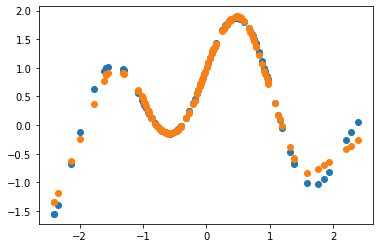

In [67]:
plt.scatter(x, y)
plt.scatter(x, forward(params, x))

In [74]:
## pytrees need a flatten and unflatten method to handle non-integer class attributes and containers
# - use jax.tree_util.register_pytree_node(container, flatten, unflatten)
# - use jax.tree_leaves(example_tree)  # print leaves

def flatten(container):
  contents = vars(container)  # need to remove the aux data, if it exists
  aux_data = [v if isinstance(v, str) else None for k, v in contents.items()]
  return contents, aux_data

In [3]:
## setup tpus in the background
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()
jax.devices()

KeyboardInterrupt: ignored

In [4]:
x = np.arange(5)
w = np.array([2., 3., 4.])

def convolve(w, x):
  output = []

  for i in range(1, len(x) - 1):
    output.append(jnp.dot(x[i - 1: i + 2], w))
  
  return jnp.array(output)

convolve(w, x)

DeviceArray([11., 20., 29.], dtype=float32)

In [5]:
# return # of cores
n_devices = jax.local_device_count()

x = np.arange(5 * n_devices).reshape(-1, 5)
w = np.stack([w] * n_devices)
print(w.shape, x.shape)

# parallize across a single core, multiple threads
vmap_result = jax.vmap(convolve, in_axes=(0, 0))(w, x)  # in_axes ensure the zeroth dimension is vertically mapped

(1, 3) (1, 5)


In [6]:
# parallize across multiple cores, in parallel
pmap_result = jax.pmap(convolve, in_axes=(0, 0))(w, x)

# parallize across multiple cores, in parallel
pmap_result = jax.pmap(convolve, in_axes=(None, 0))(w, x)  # broadcast w instead using None

In [7]:
pmap_result

ShardedDeviceArray([[11., 20., 29.]], dtype=float32)

In [8]:
def normalize_convolution(w, x):
  output = []

  for i in range(1, len(x) - 1):
    output.append(jnp.dot(x[i - 1:i + 2]), w)

  output = jnp.array(output)

  return output / jax.lax.psum(output, axis_name='batch_dum')
  

SyntaxError: ignored